In [39]:
import numpy as np
import pandas as pd

### Read cosine distance matrix and raw data 

cosine_distance = np.load('app/static/npy/cosine_sim.npy')
raw_data = pd.read_csv('app/static/datasets/netflix_titles.csv') #read data

indices = pd.Series(raw_data['title'])
cosine_sim = cosine_distance*-1 + 1

In [65]:
### Set the number of films that will be recommended

number_of_neighbors = 101 #number of indexes will taken from KNN (number of recommended movies)

In [74]:

from sklearn.decomposition import PCA
pca = PCA(n_components=20) #give the number of dimmentions
X_PCA = pca.fit_transform(cosine_distance)
## Save the PCA file (for server)
np.save('app/static/npy/pca.npy', X_PCA)

In [75]:
from sklearn.neighbors import NearestNeighbors
KNN_PCA = NearestNeighbors(n_neighbors=number_of_neighbors , algorithm='kd_tree', metric= 'cityblock')
KNN_PCA.fit(X_PCA)
#cityblock - 66
#l1 -62
#manhattan = 62

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='cityblock',
                 metric_params=None, n_jobs=None, n_neighbors=101, p=2,
                 radius=1.0)

In [76]:
KNN_distance = NearestNeighbors(n_neighbors=number_of_neighbors, algorithm='kd_tree', leaf_size=1, metric= 'chebyshev')
KNN_distance.fit(cosine_distance)

#chebyshev - 86

NearestNeighbors(algorithm='kd_tree', leaf_size=1, metric='chebyshev',
                 metric_params=None, n_jobs=None, n_neighbors=101, p=2,
                 radius=1.0)

In [77]:
# recommendation function directly from cosine and by using KNN to PCA matrix
def recommendations_cosine(title):

    recommended_movies = []

    # gettin the index of the movie that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_distance[idx]).sort_values(ascending = True)

    #print(score_series)
    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:number_of_neighbors].index)
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(raw_data['title'])[i])

    return recommended_movies


def recommendations_knn_pca(title):

    idx = indices[indices == title].index[0]

    coordinates = X_PCA[idx]
    # print(neigh.kneighbors([coordinates]))

    top_10_knn = KNN_PCA.kneighbors([coordinates])
    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(top_10_knn[1][0])
    top_10_indexes.pop(0)

    recommended_movies = []


    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(raw_data['title'])[i])

    return  recommended_movies




In [78]:
# test recommendation

name = 'Solo: A Star Wars Story (Spanish Version)'

print(recommendations_cosine(name))
print(recommendations_knn_pca(name))

['Solo: A Star Wars Story', 'LEGO Marvel Super Heroes: Guardians of the Galaxy', 'Star Wars: Episode VIII: The Last Jedi', 'Black Panther', 'Indiana Jones and the Kingdom of the Crystal Skull', 'Avengers: Infinity War', 'Spider-Man 3', 'Skyline', 'Scorpion King 5: Book of Souls', 'Æon Flux', 'Dragonheart: Battle for the Heartfire', 'Next', 'Superman Returns', 'Hulk Vs.', 'Dragonheart', 'Season of the Witch', 'Beary Tales', 'Dragonheart 3: The Sorcerer', 'Polar', 'Thor: Ragnarok', 'Hellboy', 'The Space Between Us', 'Space Cowboys', 'Indiana Jones and the Last Crusade', 'John Carter', "Cirque du Freak: The Vampire's Assistant", 'Small Soldiers', 'The Lord of the Rings: The Two Towers', 'Cloverfield', 'The Lord of the Rings: The Return of the King', 'Wyatt Earp', 'Takers', 'Godzilla', 'Men in Black II', 'The River Wild', 'Legion', 'Jupiter Ascending', 'Ant-Man and the Wasp', "Ocean's Twelve", 'The Matrix Revolutions', 'Limitless', 'Wild Wild West', "Dante's Peak", 'Austin Powers: The Spy 

In [79]:
##frunctions that gives just indexes of the recommended films

def get_top100_indexes_cosine_dis(idx):

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_distance[idx]).sort_values(ascending = True)

    # getting the indexes of the 10 most similar movies
    top_100_indexes = list(score_series.iloc[1:number_of_neighbors].index)

    return top_100_indexes

def get_top100_indexes_cosine_sim(idx):

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_100_indexes = list(score_series.iloc[1:number_of_neighbors].index)

    return top_100_indexes

def get_top100_indexes_pca(idx):

    coordinates = X_PCA[idx]
    #print(neigh.kneighbors([coordinates]))

    top_100_knn = KNN_PCA.kneighbors([coordinates])
    # getting the indexes of the 10 most similar movies
    top_100_indexes = list(top_100_knn[1][0])
    top_100_indexes.pop(0)


    return top_100_indexes

def get_top100_indexes_cos_distance_knn(idx):

    coordinates = cosine_distance[idx]
    #print(neigh.kneighbors([coordinates]))

    top_100_knn = KNN_distance.kneighbors([coordinates])
    # getting the indexes of the 10 most similar movies
    top_100_indexes = list(top_100_knn[1][0])
    top_100_indexes.pop(0)
    return top_100_indexes

In [80]:
results_pca = []
results_mds = []
result_dis_sim = []
result_distance= []
# cosine_distance.shape[0]
for i in range(cosine_distance.shape[0]): #go through all movies and take the recommended films.

    top_100_dis = get_top100_indexes_cosine_dis(i)
    top_100_sim = get_top100_indexes_cosine_sim(i)
    top_100_pca = get_top100_indexes_pca(i)
    top_100_distance_knn = get_top100_indexes_cos_distance_knn(i)
    result_dis_sim.append(len(set(top_100_dis).intersection(top_100_sim))/len(set(top_100_dis)))
    results_pca.append(len(set(top_100_dis).intersection(top_100_pca))/len(set(top_100_dis)))
    result_distance.append(len(set(top_100_sim).intersection(top_100_distance_knn))/len(set(top_100_dis)))

In [81]:
result_array_dis_sim = np.array(result_dis_sim)
print(f'accuracy between original cosine and cosine distance matrix = {result_array_dis_sim.mean()}')

result_array_pca = np.array(results_pca)
print(f'accuracy between original cosine and pca knn = {result_array_pca.mean()}')

result_array_distance_knn = np.array(result_distance)
print(f'accuracy between original cosine and cosine distance knn = {result_array_distance_knn.mean()}')


accuracy between original cosine and cosine distance matrix = 0.9984712864934232
accuracy between original cosine and pca knn = 0.49219120949631057
accuracy between original cosine and cosine distance knn = 0.831082771896054


/home/sotpak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: scipy.rand is deprecated and will be removed in SciPy 2.0.0, use numpy.random.rand instead
  from ipykernel import kernelapp as app
/home/sotpak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  app.launch_new_instance()
/home/sotpak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


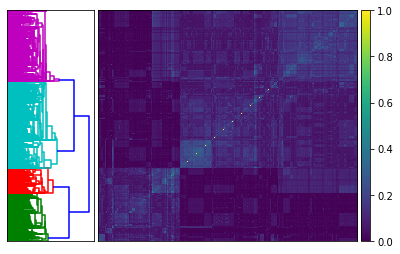

In [82]:

#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################



import scipy
import pylab
import scipy.cluster.hierarchy as sch

# Generate features and distance matrix.
x = scipy.rand(40)
D = scipy.zeros([40,40])
for i in range(40):
    for j in range(40):
        D[i,j] = abs(x[i] - x[j])
D = cosine_sim
# Compute and plot dendrogram.
fig = pylab.figure()
axdendro = fig.add_axes([0.09,0.1,0.2,0.8])
Y = sch.linkage(D, method='centroid')
Z = sch.dendrogram(Y, orientation='right')
axdendro.set_xticks([])
axdendro.set_yticks([])

# Plot distance matrix.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.8])
index = Z['leaves']
D = D[index,:]
D = D[:,index]
im = axmatrix.matshow(D, aspect='auto', origin='lower')
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.8])
pylab.colorbar(im, cax=axcolor)

# Display and save figure.
fig.show()
fig.savefig('dendrogram.png')